# Generating Supplementary figure 1. Panel B

In [1]:
import pyranges as pr
import pandas as pd
import numpy as np
import pybedtools as pbt
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image
from numpy import mean
from scipy import stats
import scipy

import random

random.seed(42)

np.random.seed(42)

## Importing files

In [2]:
# Importing genes annotation from Kallisto-provided .gtf
genes_from_annotation = pr.read_gtf("../../../mus_musculus/Mus_musculus.GRCm38.96.gtf").df
genes_from_annotation = genes_from_annotation[["gene_id", "Chromosome", "Strand", "Start", "End", "gene_name"]]
genes_from_annotation.columns = ["id", "chr", "strand", "start", "end", "name"]
genes_from_annotation["chr"] = np.array(["chr"] * len(genes_from_annotation["chr"])) + np.array(genes_from_annotation["chr"].astype(str))

# filtering out unwanted and incomplete chromosomes
genes_from_annotation = genes_from_annotation[[len(chromosome) < 6 for chromosome in genes_from_annotation['chr']]]
genes_from_annotation = genes_from_annotation[[chromosome != "chrMT" for chromosome in genes_from_annotation['chr']]]

# Importing ZGA genes
ZGA_genes_list = pd.read_csv('../../../pan_ZGA_lists/Pan_1_degree_ZGA_genes.csv')["Gene_id"].str.upper()


# Adjusting annotation and creating ZGA and non-ZGA data frames
window_before_TSS = 8000
Non_ZGA_genes_from_annotation = genes_from_annotation[~genes_from_annotation["name"].str.upper().isin(ZGA_genes_list)]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation.drop_duplicates(subset='name', keep='first')
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation[["chr", "start", "end", "strand", "name"]]
start = [x - window_before_TSS if z == "+" else y for x, y, z in zip(Non_ZGA_genes_from_annotation["start"], Non_ZGA_genes_from_annotation["end"], Non_ZGA_genes_from_annotation["strand"])]
end = [x if z == "+" else y + window_before_TSS for x, y, z in zip(Non_ZGA_genes_from_annotation["start"], Non_ZGA_genes_from_annotation["end"], Non_ZGA_genes_from_annotation["strand"])]
Non_ZGA_genes_from_annotation["start"] = start
Non_ZGA_genes_from_annotation["end"] = end
Non_ZGA_genes_from_annotation.columns = [0,1,2,3,4]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation[[0,1,2,4]]
Non_ZGA_genes_from_annotation.columns = ["Chromosome", "Start", "End", "name"]
Non_ZGA_genes_from_annotation = Non_ZGA_genes_from_annotation.sample(frac = 1)

ZGA_genes_from_annotation = genes_from_annotation[genes_from_annotation["name"].str.upper().isin(ZGA_genes_list)]
ZGA_genes_from_annotation = ZGA_genes_from_annotation.drop_duplicates(subset='name', keep='first')
ZGA_genes_from_annotation = ZGA_genes_from_annotation[["chr", "start", "end", "strand", "name"]]
start = [x - window_before_TSS if z == "+" else y for x, y, z in zip(ZGA_genes_from_annotation["start"], ZGA_genes_from_annotation["end"], ZGA_genes_from_annotation["strand"])]
end = [x if z == "+" else y + window_before_TSS for x, y, z in zip(ZGA_genes_from_annotation["start"], ZGA_genes_from_annotation["end"], ZGA_genes_from_annotation["strand"])]
ZGA_genes_from_annotation["start"] = start
ZGA_genes_from_annotation["end"] = end
ZGA_genes_from_annotation.columns = [0,1,2,3,4]
ZGA_genes_from_annotation = ZGA_genes_from_annotation[[0,1,2,4]]
ZGA_genes_from_annotation.columns = ["Chromosome", "Start", "End", "name"]
ZGA_genes_from_annotation = ZGA_genes_from_annotation.sample(frac = 1)

In [3]:
# Please use https://genome.ucsc.edu/cgi-bin/hgTables or download directly with wget

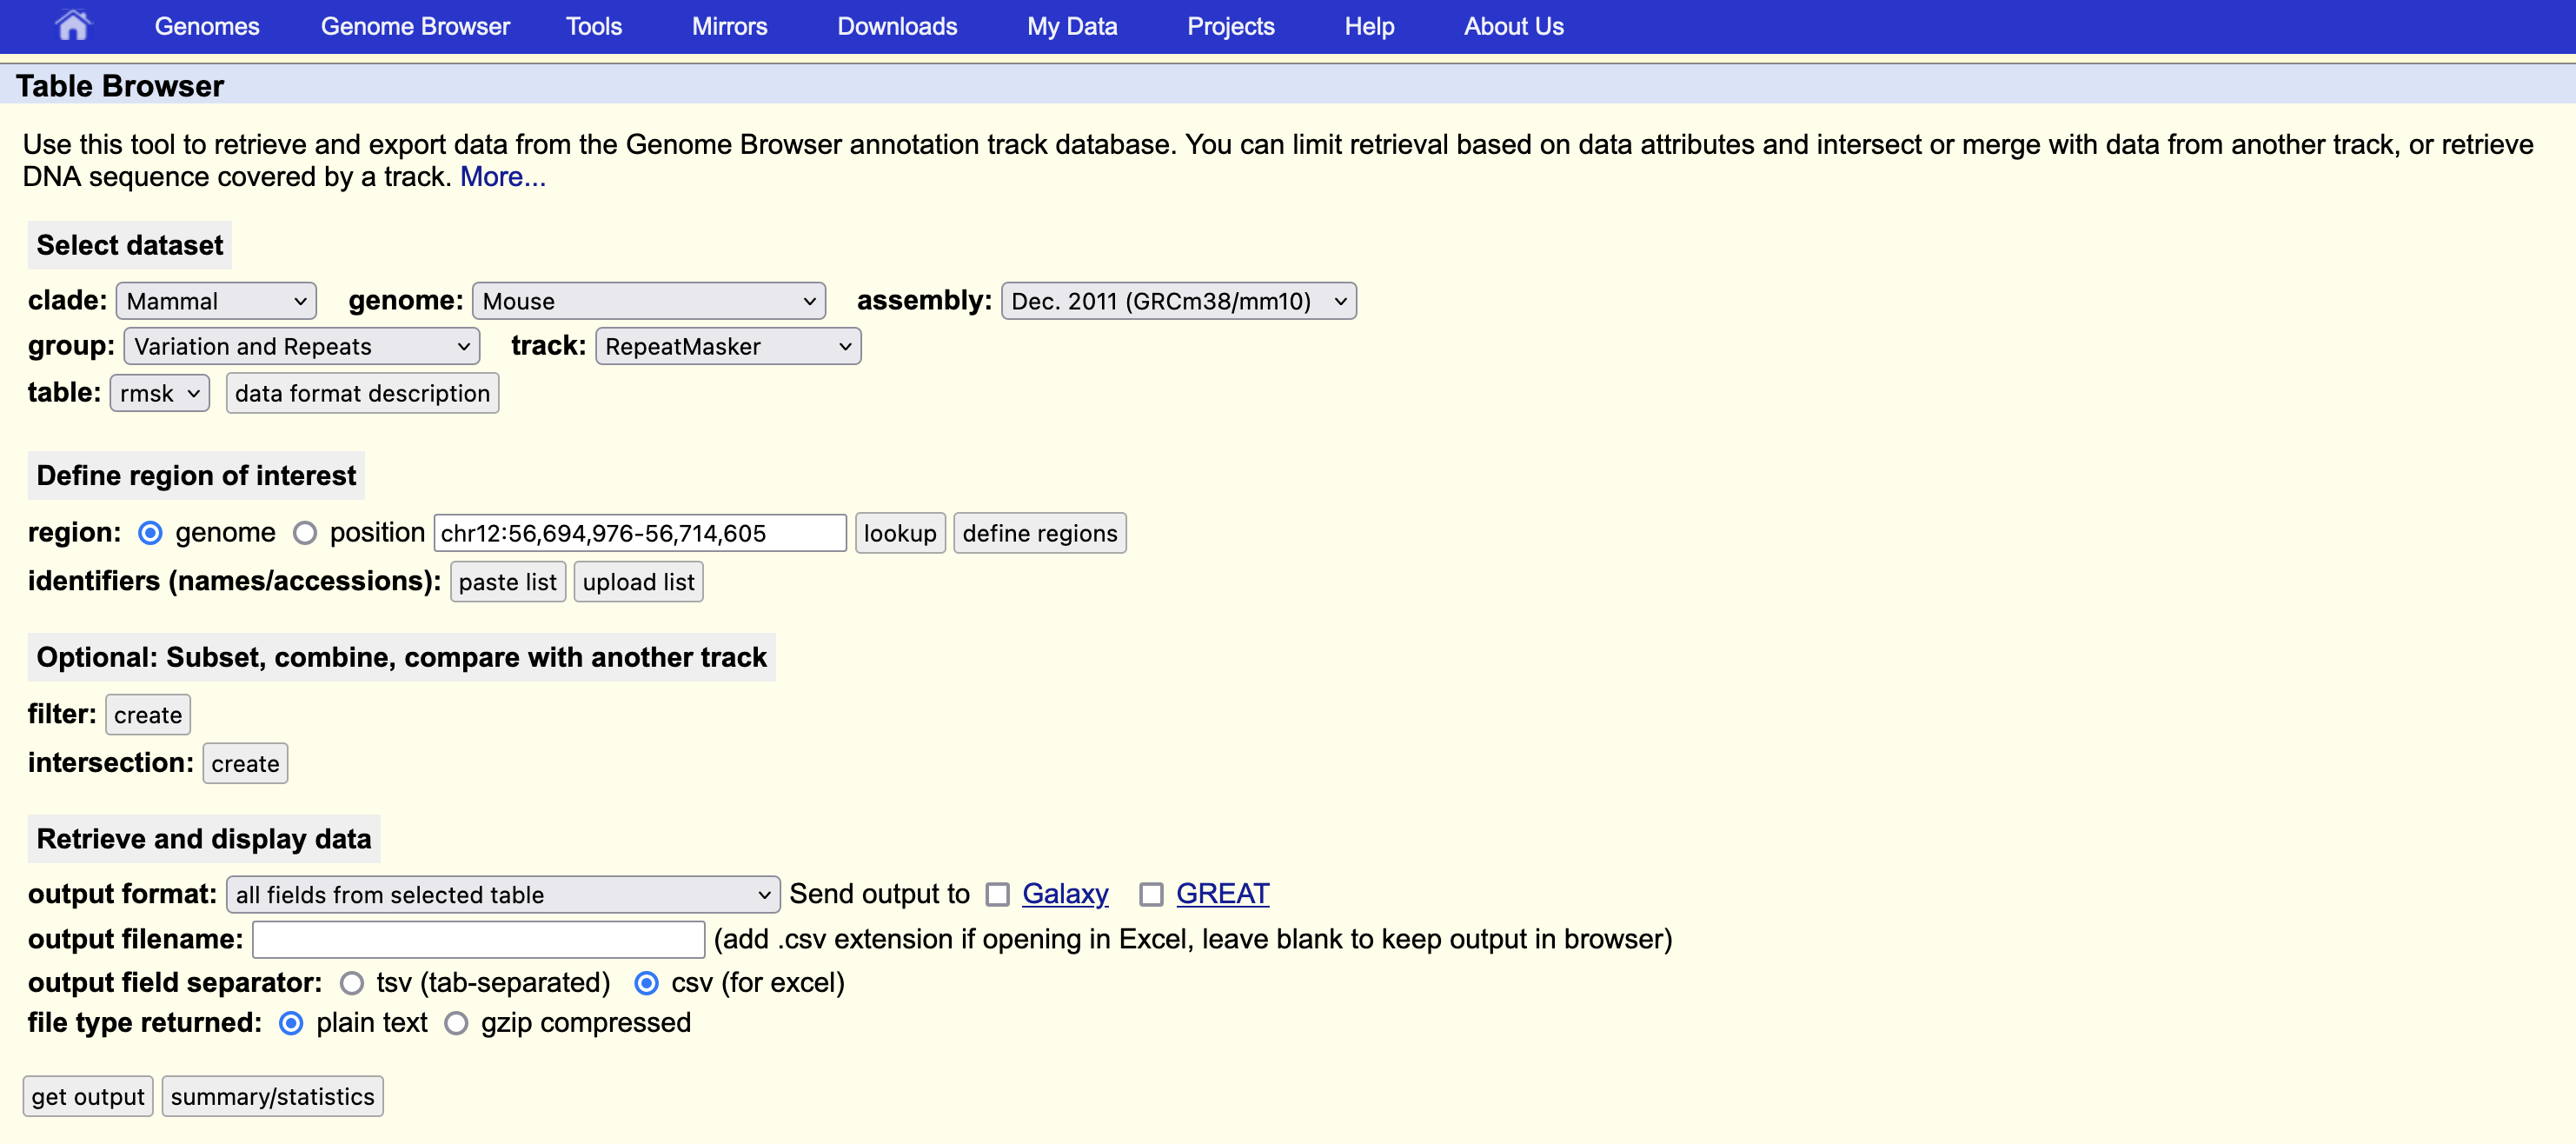

In [4]:
Image(filename="./mm10_repeatmasker.png")

In [3]:
# Importing mm10_repeatmasker table
mm10_repeatmasker = pd.read_csv('../../../mm10_repeatmasker.csv', sep="\t", header=None)
mm10_repeatmasker.columns = ['#bin', 'swScore', 'milliDiv', 'milliDel', 'milliIns', 'genoName',
       'genoStart', 'genoEnd', 'genoLeft', 'strand', 'repName', 'repClass',
       'repFamily', 'repStart', 'repEnd', 'repLeft', 'id']
mm10_repeatmasker = mm10_repeatmasker[["genoName","genoStart","genoEnd","strand","repName","repClass","repFamily"]].dropna()
mm10_repeatmasker = mm10_repeatmasker[["genoName","genoStart","genoEnd", "strand", "repFamily"]]
mm10_repeatmasker.columns = ["Chromosome", "Start", "End", "Strand", "repFamily"]
mm10_repeatmasker = mm10_repeatmasker.drop_duplicates()
mm10_repeatmasker = mm10_repeatmasker[[True if len(chromosome) < 6 else False for chromosome in list(mm10_repeatmasker["Chromosome"])]]
mm10_repeatmasker_Alu = mm10_repeatmasker[mm10_repeatmasker["repFamily"] == "Alu"]

In [9]:
mm10_repeatmasker

,Chromosome,Start,End,Strand,repFamily
0,chr1,3000000,3002128,-,L1
1,chr1,3003152,3003994,-,L1
2,chr1,3003993,3004054,-,L1
3,chr1,3004040,3004206,+,L1
4,chr1,3004206,3004270,+,Simple_repeat
...,...,...,...,...,...
5146451,chrY,90838012,90838289,-,L1
5146452,chrY,90838299,90838481,-,ERVL-MaLR
5146453,chrY,90838554,90838722,-,ERVL-MaLR
5146454,chrY,90843304,90843490,+,hAT-Charlie


In [4]:
# Calculating cross-validation set size for 10 batches
cv=10
ZGA_len = ZGA_genes_from_annotation.shape[0]
cv_set_size = int(ZGA_len/cv)
print("cv_set_size =", cv_set_size)

cv_set_size = 127


## Intersecting bed files for ZGA, non-ZGA and random control

In [5]:
ZGA_genes_from_annotation_pbt = pbt.BedTool.from_dataframe(ZGA_genes_from_annotation)
Non_ZGA_genes_from_annotation_pbt = pbt.BedTool.from_dataframe(Non_ZGA_genes_from_annotation)
mm10_repeatmasker_Alu_pbt = pbt.BedTool.from_dataframe(mm10_repeatmasker_Alu)
ZGA_len = ZGA_genes_from_annotation.shape[0]

# ZGA
df = pbt.BedTool.intersect(ZGA_genes_from_annotation_pbt, 
                           mm10_repeatmasker_Alu_pbt, c=True).to_dataframe()
df["RE"] = np.array(df["score"])
ZGAdf = df.sample(cv_set_size)
cntZGAdf = df.sample(cv_set_size)
df_tmp_list = []
for i in range(cv):
    df_tmp_list.append(np.array(df["RE"][i*cv_set_size:i*cv_set_size+cv_set_size]))    
ZGAdf["RE"] = np.nanmedian(df_tmp_list, axis=0)

# Non-ZGA
df = pbt.BedTool.intersect(Non_ZGA_genes_from_annotation_pbt, 
                           mm10_repeatmasker_Alu_pbt, c=True).to_dataframe()
df["RE"] = np.array(df["score"])
nonZGAdf = df.sample(cv_set_size)
df_tmp_list = []
for i in range(cv):
    df_tmp_list.append(np.array(df["RE"][i*cv_set_size:i*cv_set_size+cv_set_size]))    
nonZGAdf["RE"] = np.nanmedian(df_tmp_list, axis=0)

# Control
df_tmp_list = []
for i in range(cv):
    df = pbt.BedTool.intersect(pbt.BedTool.from_dataframe(ZGA_genes_from_annotation.iloc[i*cv_set_size:i*cv_set_size+cv_set_size,]), 
                               mm10_repeatmasker_Alu_pbt.shuffle(genome='mm10', chrom=True, seed=42), c=True).to_dataframe()
    df_tmp_list.append(np.array(df["score"])) 
cntZGAdf["RE"] = np.nanmedian(df_tmp_list, axis=0)

In [6]:
ZGAdf["Group"] = "ZGA genes"
nonZGAdf["Group"] = "Non-ZGA genes"
cntZGAdf["Group"] = "ZGA genes, \n shuffled RE"

In [7]:
mean(nonZGAdf["RE"])

1.8858267716535433

In [8]:
mean(ZGAdf["RE"])

6.2204724409448815

In [9]:
barplot_df = pd.concat([ZGAdf, nonZGAdf, cntZGAdf], axis=0)

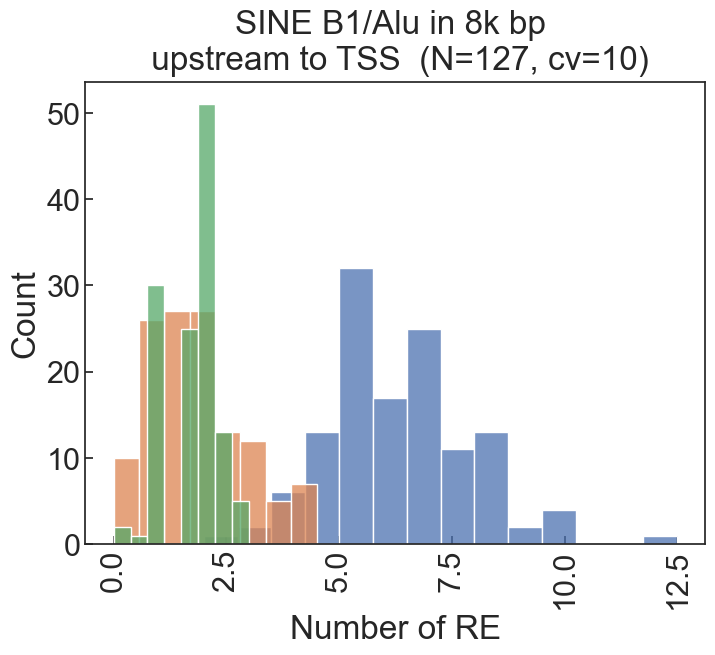

In [10]:
sns.set(font_scale=2, style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams['font.weight'] = "medium"
matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)


for i in [ZGAdf, nonZGAdf, cntZGAdf]:
    sns.histplot(i.RE)
    
ax.set(xlabel='Number of RE', ylabel="Count")
plt.title(f"SINE B1/Alu in 8k bp \n upstream to TSS  (N={cv_set_size}, cv=10)", y=1.01) 
plt.xticks(rotation=90)

plt.show() 

## Plotting RE abundancy before genes

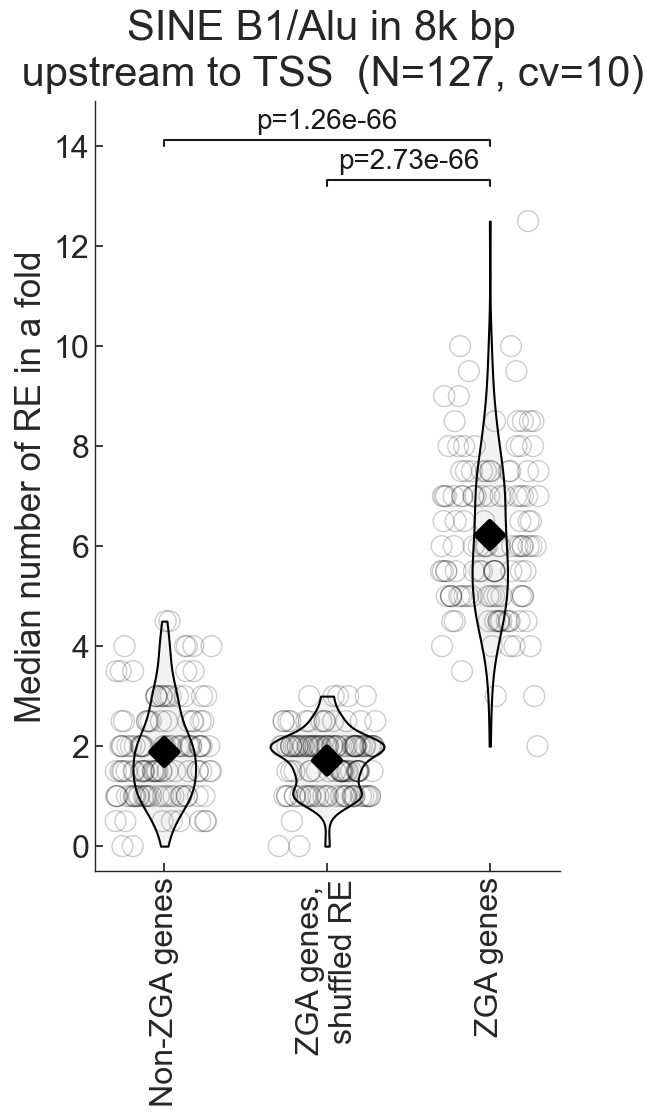

In [19]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def convert_pvalue_to_asterisks(pvalue):
    
    if pvalue <= 0.05:
        scientific_notation="{:.2e}".format(pvalue)
        return "p=" + str(scientific_notation)
    return "ns"

def precision_round(number, digits=3):
    power = "{:e}".format(number).split('e')[1]
    return round(number, -(int(power) - digits))


sns.set(font_scale=2.1, style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
matplotlib.rcParams['font.weight'] = "medium"
matplotlib.rcParams['axes.labelweight'] = 'medium'
matplotlib.rcParams['figure.titleweight'] = 'medium'
matplotlib.rcParams['axes.titleweight'] = 'medium'
matplotlib.rcParams['figure.figsize'] = 6, 10
sns.despine()

matplotlib.rcParams['axes.linewidth'] = 1
Group = ["Non-ZGA genes","ZGA genes, \n shuffled RE", "ZGA genes"]

ax = sns.violinplot(x="Group", y="RE", data=barplot_df, inner=None, linewidth=1.5, saturation=10,
                    order=Group, showfliers = False, width=0.7, zorder=1,cut=0)

ax = sns.stripplot(x="Group", y="RE", data=barplot_df, color="gray", edgecolor="black", 
                    order=Group, alpha=.2, s=15, linewidth=1, zorder=1, jitter=0.3, facecolors="none")

[ax.collections[i].set_edgecolor((0, 0, 0, 1)) for i in range(len(Group))]
[ax.collections[i].set_facecolor((0, 0, 0, 0.05)) for i in range(len(Group))]

ax = sns.pointplot(x="Group", y="RE", data=barplot_df, estimator=mean, order=Group, color="black", scale=2,
                   join=False, errwidth=0,capsize=0, markers='D') #['o', 's', 'p', 'x', '^', '+', '*', '<', 'D', 'h', '>']


lw = 1.5
size = 20
x2 = 2
equal_var = False

for j in reversed(range(x2)):
    x1 = j
    max_col = 13
    for i in reversed(range(x2)):
        max_col = max(max_col, np.percentile(barplot_df["RE"][(barplot_df["Group"]==Group[i])], 100))

    t_stat = stats.ttest_ind(barplot_df["RE"][(barplot_df["Group"]==Group[x2])], barplot_df["RE"][(barplot_df["Group"]==Group[j])], equal_var = equal_var)
    y, h, col = max_col+1-0.8*j, max_col*0.01, 'k'
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c=col)
    plt.text((x1+x2)*.5, y+h+0.1, convert_pvalue_to_asterisks(t_stat.pvalue), ha='center', va='bottom', color=col, size=size)

ax.grid(False)
plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax.lines, color='k')
sns.set(font_scale=2.5, style="ticks", font="Lato")
ax.set(ylabel='Median number of RE in a fold', xlabel="")
plt.title(f"SINE B1/Alu in 8k bp \n upstream to TSS  (N={cv_set_size}, cv=10)", y=1.01) 
plt.xticks(rotation=90)
plt.ylim(-0.5,14.9)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig("./Panel_B.pdf")
plt.show()